In [1]:
import torch
from torch import optim
from torch.nn.functional import cross_entropy

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
from src.custom_audio_dataset import CustomAudioDataset
from src.models import CnnMFCC
from src.utils import pad_collate_fn, plot_spectrogram
from src.datasets import get_data_path
from src.custom_layers import PadOrTruncateLayer
from src.hesitation import coraa_filters

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MAX_EPOCH = 20

TRAIN_SIZE = 0.6
TEST_FROM_VAL_SIZE = 0.5

SAMPLE_RATE = 16_000
MAX_SECONDS_DURATION = 8

MAX_FEATURES_IN = SAMPLE_RATE * MAX_SECONDS_DURATION

In [6]:
annotations_file_path, data_dir_path = get_data_path("hesitation_dev")

train_filter0_annotations_file, val_filter0_annotations_file, test_filter0_annotations_file = coraa_filters.filter0(
    annotations_file_path, train_size=TRAIN_SIZE, test_size_from_val_size=TEST_FROM_VAL_SIZE
	)

In [7]:
data_transform = torch.nn.Sequential(
    PadOrTruncateLayer(MAX_FEATURES_IN)
)

train_filter0_dataset = CustomAudioDataset(train_filter0_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=data_transform)
val_filter0_dataset = CustomAudioDataset(val_filter0_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=data_transform)
test_filter0_dataset = CustomAudioDataset(test_filter0_annotations_file, data_dir_path, column_predict_name="has_hesitation", data_transform=data_transform)

# Usage in DataLoader
train_filter0_dataloader = torch.utils.data.DataLoader(
    dataset=train_filter0_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)
val_filter0_dataloader = torch.utils.data.DataLoader(
    dataset=val_filter0_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)
test_filter0_dataloader = torch.utils.data.DataLoader(
    dataset=test_filter0_dataset,
    batch_size=32,
    # collate_fn=pad_collate_fn
)

In [8]:
model = CnnMFCC(n_classes=2, sample_rate=SAMPLE_RATE, max_audio_length_seconds=MAX_SECONDS_DURATION)
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.003)
model

/home/glucas11/projects/repos/speech_feedback/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


CnnMFCC(
  (feature_extractor): Sequential(
    (0): MFCC(
      (amplitude_to_DB): AmplitudeToDB()
      (MelSpectrogram): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
    )
  )
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=1248, out_features=2, bias=True)
  )
)

In [9]:
for i in range(MAX_EPOCH):
	losses = []
	for batch_idx, (data, target) in enumerate(train_filter0_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		loss = cross_entropy(logits, target)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
	print(sum(losses)/len(losses))

1.4569520354270935
0.5295193552970886
0.5367430746555328
0.46758887767791746
0.446172921359539
0.40727830678224564
0.39617403596639633
0.4263394795358181
0.3132245361804962
0.3190376624464989
0.2662693396443501
0.32435222491621973
0.24019220769405364
0.25118832737207414
0.19047817401587963
0.16923053413629532
0.14647961743175983
0.11771782720461488
0.09430915070697665
0.07396913007833064


In [10]:
preds = []
targets = []
with torch.no_grad():
	for batch_idx, (data, target) in enumerate(test_filter0_dataloader):
		optimizer.zero_grad()
		data, target = data.to(DEVICE), target.to(DEVICE)
		logits = model(data)
		preds.append(torch.max(logits, dim=1).indices)
		targets.append(target)

preds = torch.concat(preds)
targets = torch.concat(targets)

sum(preds == targets)/len(preds)

tensor(0.9699, device='cuda:0')

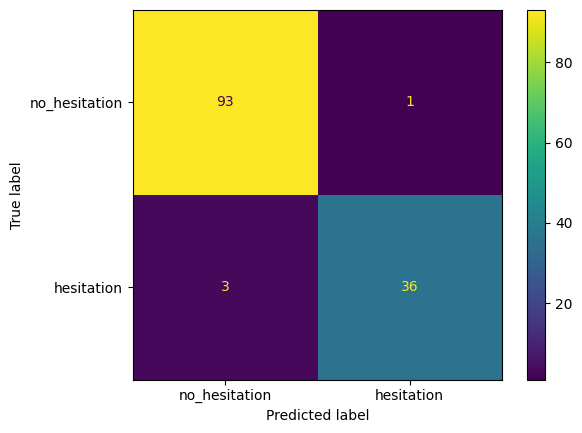

In [11]:
cm =confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no_hesitation', 'hesitation'])

disp.plot()
plt.show()